# Spectral FPM Simulation and Reconstruction Code

Neerja Aggarwal

Sep 20th, 2023

Now let's have our object be spectrally varying.  For this, first let's assume that we have a resolution target that has the same spectrum across pixels.  And let's insert a filter in the fourier plane.  3x3 where each cell lets through one of the wavelength channels. 

## Import and Setup

In [1]:
# load relevant libraries
# activate pytorch conda environment on fuoco

%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import image
import math
import os
import scipy.signal

plt.style.use('dark_background')

# TODO: need to install tex and Helvetica to use:
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Helvetica"
# })

/home/neerja/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# set up to use the gpu
# ACTION: CHOOSE WHICH GPU TO USE (0-3)
use_gpu = True
gpu = 1
if use_gpu:
    os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
    torch.cuda.set_device(gpu)
    device = torch.device("cuda:"+str(gpu) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device('cpu') # uncomment this line to use cpu
torch.cuda.empty_cache()  #empty any variables in cache to free up space
print(device)



cuda:1


CHANGE experiment parameters here:

In [3]:
# set the following parameters
mag = 4 # 4x 
na_obj = 0.1 # low na objective 
pix_size_camera = 4 #  micron"

wv_start = 400e-3 # micron
wv_end = 800e-3 # micron
wv_step = 50e-3 # micron

# these are computed automatically
wv_range = np.arange(wv_start,wv_end, wv_step) # spectral channel center vector
Nw = len(wv_range)
pix_size_object =pix_size_camera/mag # micron  

# Create helper functions

In [4]:
# start with an image in the object plane
# let's load a high resolution res target and just upsample for now?  we'll just do a mini version with limited angles. 
path = '../../DATA/SpectralFPMData/usafrestarget.jpeg'
im = torch.from_numpy(image.imread(path))[:,:,0] # pick out the first channel

def preprocessObject(im):
    (Ny,Nx) = im.shape
    # make image square
    if Ny<Nx:
        im = im[:,1:Ny]
    elif Nx<Ny:
            im = im[1:Nx,:]
    # make even dimensions
    if Ny % 2 != 0:
        im = im[:-1,:]
    if Nx % 2 != 0:
        im = im[:,:-1]
    return im
def makeSpectralObject(im,spectrum):
    obj = torch.unsqueeze(im,0)
    obj = obj*spectrum
    return obj

im = preprocessObject(im)
(Ny,Nx) = im.shape
Npixel = Ny

In [8]:
#helper functions for false coloring
def gauss(x, mean, std):
    return 1/(std*np.sqrt(6.28))*np.exp(-(x-mean)**2/(2*std**2))

def gauss_green(x):
    std = 20
    mean = 550
    return 1/(std*np.sqrt(6.28))*np.exp(-(x-mean)**2/(2*std**2))

def gauss_red(x):
    std = 50
    mean = 625
    return 1/(std*np.sqrt(6.28))*np.exp(-(x-mean)**2/(2*std**2))

def gauss_blue(x):
    std = 42
    mean = 450
    return 1/(std*np.sqrt(6.28))*np.exp(-(x-mean)**2/(2*std**2))

def make_false_color_filter(waves, scaling=[1,1,2.5], device = 'cpu'):
    red_filt = gauss_red(waves)
    red_filt = torch.tensor(red_filt/np.max(red_filt)*scaling[0]).unsqueeze(-1).unsqueeze(-1)

    green_filt = gauss_green(waves)
    green_filt = torch.tensor(green_filt/np.max(green_filt)*scaling[1]).unsqueeze(-1).unsqueeze(-1)

    blue_filt = gauss_blue(waves)
    blue_filt = torch.tensor(blue_filt/np.max(blue_filt)*scaling[2]).unsqueeze(-1).unsqueeze(-1)

    return torch.stack([red_filt, blue_filt, green_filt])

def make_false_color_img(img, filt):
    return torch.sum(img.unsqueeze(0)*filt, 1).permute(1,2,0)

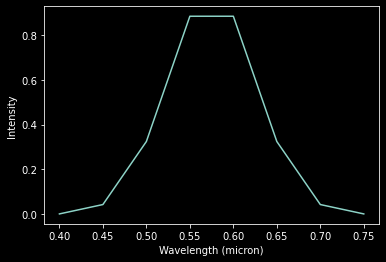

In [9]:
# make into spectral object
gauss_spec = torch.Tensor(scipy.signal.windows.gaussian(Nw, std = 1.0))
plt.plot(wv_range,gauss_spec)
plt.xlabel('Wavelength (micron)')
plt.ylabel('Intensity')
spectrum = torch.ones([Nw,1,1])*torch.unsqueeze(torch.unsqueeze(gauss_spec, 1),2)  # create a spectrum vector with dimension (Nw, 1,1)
spectral_im = im.unsqueeze(0)*spectrum  # elementwise multiply with the sample after expanding dim0 to be wavelength

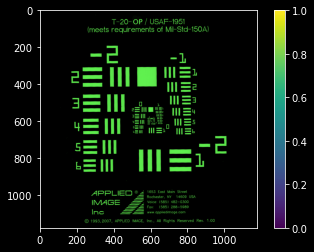

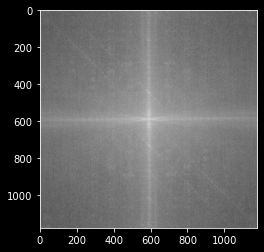

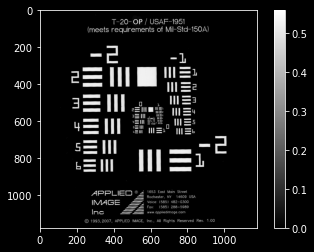

In [20]:
# implement false color
filt = make_false_color_filter(wv_range)
sim_xy = make_false_color_img(spectral_im, filt)
sim_xy = sim_xy/torch.amax(sim_xy) # normalize before plotting
# look at image
plt.imshow(sim_xy)
plt.colorbar()

# look at the projction along wavelength's fourier transform.
pup_obj = torch.fft.fftshift(torch.fft.fft2(torch.sum(spectral_im, dim=0)))
plt.figure()
plt.imshow(torch.log10(torch.abs(pup_obj)),'gray')


# look at single channel
plt.figure()
sim_0 = spectral_im[0,:,:]
plt.imshow(sim_0,'gray')
plt.colorbar()


Text(0.5, 1.0, 'wv = 750nm')

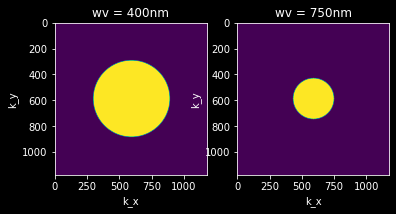

In [21]:
# make pupil mask
def createPupilStop(na_obj, wv, pix_size_object, Npixel):
    fPupilEdge = na_obj/wv # edge of pupipl is NA/wavelength
    fMax = 1/(2*pix_size_object)
    df = 1/(Ny*pix_size_object) # assume square image
    fvec = np.arange(-fMax,fMax,df)
    fxc,fyc = np.meshgrid(fvec,fvec)
    # caclulate radius of f coordinates
    frc = np.sqrt(fxc**2+fyc**2)
    pupil = np.zeros_like(frc) 
    pupil[frc<fPupilEdge] = 1 # make everything inside fPupilEdge transmit 100%
    return torch.Tensor(pupil)

pupilstack = torch.zeros([Nw,Ny,Nx])
for k in np.arange(Nw):
    wv = wv_range[k]
    pupilstack[k,:,:]  = createPupilStop(na_obj,wv,pix_size_object, Npixel)

k =0
plt.subplot(1,2,1)
plt.imshow(pupilstack[k,:,:])
plt.xlabel('k_x')
plt.ylabel('k_y')
plt.title('wv = ' + str(int(wv_range[k]*1000)) + "nm")

k=-1
plt.subplot(1,2,2)
plt.imshow(pupilstack[k,:,:])
plt.xlabel('k_x')
plt.ylabel('k_y')
plt.title('wv = ' + str(int(wv_range[k]*1000)) + "nm")

Text(0.5, 1.0, 'wv = 750nm')

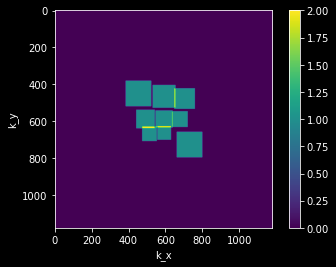

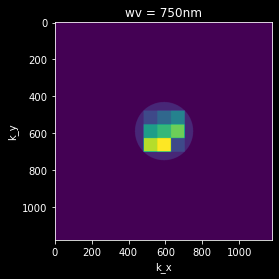

In [22]:
# make aperture
# let's say our apperture is defined in physical xy space?  Then it needs to be converted into kx, ky space for each wavelength. 

def createTile(Nw):
    a = np.arange(1,Nw+1) # get vector from 0 to Nw-1
    s = np.ceil(np.sqrt(Nw)).astype(int) # compute sqrt of number of channels and round up to the next integer.  Ex: sqrt(8)--> 3x3 matrix
    a = np.resize(a, (s,s))
    return(a)

def createApertureFromTile(a,na_obj,ind, wv, pix_size_object, Ny,Nx):
    df = 1/(Ny*pix_size_object)
    f_width = na_obj/wv*np.sqrt(2) # side of largest square that can fit in circle pupil 
    f_width_ind = np.floor(f_width/df).astype(int)
    mul_factor = int(f_width_ind/a.shape[0]) # assume you want square apperture
    aperture = np.repeat(np.repeat(a, mul_factor, axis = 0), mul_factor, axis = 1) # stretch the filter array

    # pad into appropriate size
    pady = int((Ny-f_width_ind)/2)+1
    padx = int((Nx-f_width_ind)/2)+1
    aperture = np.pad(aperture, ((pady, pady),(padx,padx)))
    aperture = aperture[0:Ny,0:Nx] # correct size
    if aperture.shape[0] != Ny or aperture.shape[1] != Nx:
        print('aperture matrix size incorrect!') # catch remaining error

    # pick out into channels
    frame = np.zeros((Ny,Nx))
    frame[np.where(aperture == ind)] = 1
    return (torch.Tensor(frame), torch.Tensor(aperture))


aperture_stack = torch.zeros([Nw,Ny,Nx])
tile = createTile(Nw) # motif for filter array. 
for k in np.arange(Nw):
    wv = wv_range[k]
    (aperture_stack[k,:,:], aperture) = createApertureFromTile(tile,na_obj,k+1, wv, pix_size_object, Ny,Nx)

plt.imshow(torch.sum(aperture_stack,axis = 0))
plt.colorbar()
plt.xlabel("k_x")
plt.ylabel('k_y')

k=-1
plt.figure()
plt.imshow(pupilstack[k,:,:]+aperture)
plt.xlabel('k_x')
plt.ylabel('k_y')
plt.title('wv = ' + str(int(wv_range[k]*1000)) + "nm")


Text(0, 0.5, 'Y')

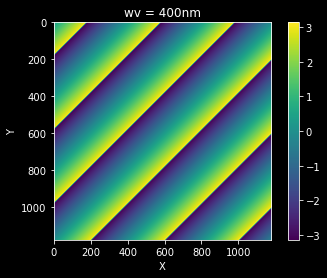

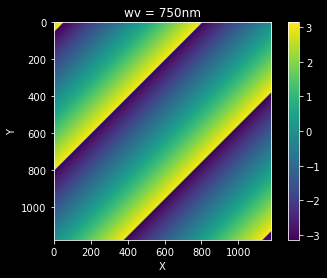

In [23]:
# create xy grid for object space (used for illumination field)
def createXYgrid(pix_size_object,Nx,Ny):
    xvec = np.arange(-pix_size_object*Nx/2,pix_size_object*Nx/2,pix_size_object)
    yvec = np.arange(-pix_size_object*Ny/2,pix_size_object*Ny/2,pix_size_object)
    xygrid = torch.Tensor(np.array(np.meshgrid(xvec,yvec)))
    return xygrid

# create the illumination field given angle of planewave
def createIllumField(xygrid, illum_angle, wv):
    rady = illum_angle[0]
    radx = illum_angle[1]
    k0 = 2*math.pi/wv
    ky = k0*math.sin(rady)
    kx = k0*math.sin(radx)
    field = torch.exp(1j*kx*xygrid[1] + 1j*ky*xygrid[0])
    return field

# look at an example illumination field
illum_angle = (.001,.001)  # y,x  # unit is in radians
xygrid = createXYgrid(pix_size_object,Nx,Ny)


# create stack of illum field
illumstack = torch.zeros([Nw,Ny,Nx],dtype = torch.complex64)  # use complex dtype
for k in np.arange(Nw):
    wv = wv_range[k]
    illumstack[k,:,:] = createIllumField(xygrid,illum_angle,wv)

k=0
field = illumstack[k,:,:]
plt.figure()
plt.imshow(torch.angle(field))
plt.title('wv = ' + str(int(wv_range[k]*1000)) + "nm")
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')

k=-1
field = illumstack[k,:,:]
plt.figure()
plt.imshow(torch.angle(field))
plt.title('wv = ' + str(int(wv_range[k]*1000)) + "nm")
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')



<Figure size 432x288 with 0 Axes>

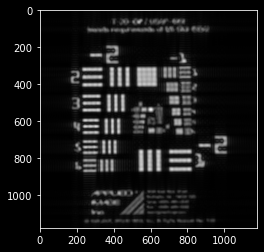

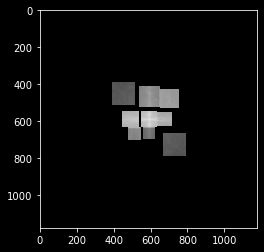

<Figure size 432x288 with 0 Axes>

In [24]:
# compute the measurement given an object and incident wave field and pupil stop
def forwardSFPM(objstack, pupilstack, illumstack, Nw):
    # multiply by the sample
    for k in torch.arange(Nw):
        obj = objstack[k]
        pupil = pupilstack[k]
        field = illumstack[k]
        obj_field = field*obj
        # take the fourier transform and center in pupil plane
        pup_obj = torch.fft.fftshift(torch.fft.fft2(obj_field))*pupil
        # multiply object's FFT with the pupil stop and take ifft to get measurement
        if k==0:
            y = torch.abs(torch.fft.ifft2(torch.fft.fftshift(pup_obj)))
            pup_out = pup_obj 
        else:
            y = y+torch.abs(torch.fft.ifft2(torch.fft.fftshift(pup_obj)))
            pup_out = pup_out + pup_obj 
        # subsample according to pixel size on camera?
    return (y, pup_out)

# look at an example measurement
(y, pup_obj) = forwardSFPM(spectral_im,aperture_stack, illumstack, Nw)
plt.imshow(torch.abs(y),'gray')
plt.figure()
plt.imshow(torch.log10(torch.abs(pup_obj)),'gray')
plt.figure()


## Simulate lots of forward measurements


In [27]:
# create list of illumination angles (leds) to turn on one at a time
def createlist_led(num_leds,minval,maxval):
    list_leds = np.random.uniform(low = minval, high = maxval, size = (num_leds,2))
    # append a (0,0) bf led
    list_leds = np.append(list_leds,np.zeros([1,2]), axis = 0 )
    return list_leds

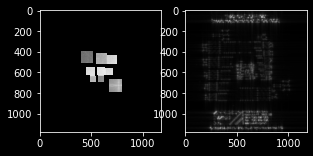

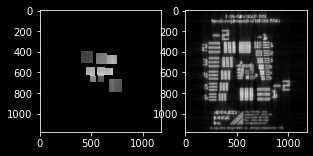

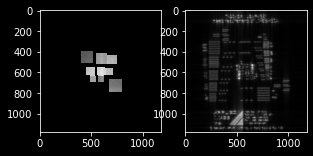

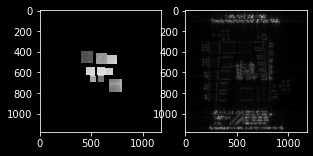

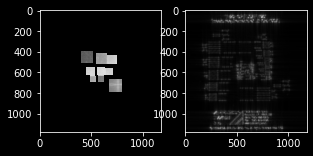

In [28]:
d = 75 # distance away led to object
# let's go up to 15 mm out (15/5 = 3)
led_spacing = 5 # roughly 5 mm apart LEDs
list_leds = createlist_led(100,0,3) 
num_meas = len(list_leds) 
# load data
path = '../../DATA/SpectralFPMData/usafrestarget.jpeg'
obj = torch.from_numpy(image.imread(path))[:,:,0] # pick out the first channel
obj = preprocessObject(obj) # make it square and even
(Ny,Nx) = obj.shape
Npixel = Ny

# create grid
xygrid = createXYgrid(pix_size_object,Nx,Ny)

# # do not need to create pupil since we are using the aperture
# pupilstack = torch.zeros([Nw,Ny,Nx])
# for k1 in np.arange(Nw):
#     wv = wv_range[k1]
#     pupilstack[k1,:,:]  = createPupilStop(na_obj,wv,pix_size_object, Npixel)

# create aperture stacks
aperture_stack = torch.zeros([Nw,Ny,Nx])
tile = createTile(Nw) # motif for filter array. 
for k in np.arange(Nw):
    wv = wv_range[k]
    (aperture_stack[k,:,:], aperture) = createApertureFromTile(tile,na_obj,k+1, wv, pix_size_object, Ny,Nx)

# create measurement stack
measstack = torch.zeros(num_meas,Ny,Nx)

#start iterating through LEDs
for k2 in np.arange(num_meas):
    # take led indices and calculate angle of incidence
    led_ind = list_leds[k2]  
    led_pos = (led_ind[0]*led_spacing,led_ind[1]*led_spacing,d) # units = millimeters, (x,y,z)
    illum_angle = (np.arctan(led_pos[1]/led_pos[2]), np.arctan(led_pos[0]/led_pos[2]))

    # create illumination field stack 
    illumstack = torch.zeros([Nw,Ny,Nx],dtype = torch.complex64)  # use complex dtype
    for k1 in np.arange(Nw):
        wv = wv_range[k]
        illumstack[k1,:,:] = createIllumField(xygrid,illum_angle,wv)
        
    # simulate the forward measurement
    (y, pup_obj) = forwardSFPM(spectral_im,aperture_stack, illumstack, Nw)
    # print(k2)
    # plot some example measurements
    if k2<5:
        plt.figure(figsize=(10,10))
        plt.subplot(1,4,1)
        plt.imshow(torch.log10(torch.abs(pup_obj)),'gray')
        plt.subplot(1,4,2)
        plt.imshow(torch.abs(y),'gray')
    measstack[k2,:,:] = y


In [29]:
def computesize(a):
    return(a.element_size() * a.nelement() /1e9)

print(computesize(measstack))
print(computesize(spectral_im))
print(computesize(aperture_stack))

0.560624336
0.044405888
0.044405888


## Reconstruction

In [30]:
# need regular FPM function 
# compute the measurement given an object and incident wave field and pupil stop
def forwardFPM(obj, pupil, field):
    # multiply by the sample
    obj_field = field*obj
    # take the fourier transform and center in pupil plane
    pup_obj = torch.fft.fftshift(torch.fft.fft2(obj_field))*pupil
    # multiply object's FFT with the pupil stop and take ifft to get measurement
    y = torch.abs(torch.fft.ifft2(torch.fft.fftshift(pup_obj)))
    # subsample according to pixel size on camera?
    return (y, pup_obj)

In [31]:
# obj_est = torch.zeros_like(obj,dtype = torch.float) # initializing to zeros doesn't work well. 
# obj_est = measstack[0,:,:] # initialize to first measurement instead
init_spectrum = torch.ones([Nw,1,1])  # create a spectrum vector with dimension (Nw, 1,1)
obj_est = measstack[0,:,:].unsqueeze(0)*init_spectrum
obj_est.requires_grad = True
# regularizers
def hardthresh(x,val):
    return torch.maximum(x,torch.tensor(val))

# set hyperparameters
step_size = 1e1
num_iters = 100
num_meas = len(list_leds)

# move to gpu
if use_gpu == 1:
    with torch.no_grad():
        obj_est = obj_est.to(device)
        aperture_stack = aperture_stack.to(device)
        measstack = measstack.to(device)
        obj_est.requires_grad = True
        
# loop through iterations
for k1 in np.arange(num_iters):
    # loop through measurement
    for k2 in np.arange(num_meas): 
        print(k1,k2)
        # get relevant actual measurement and move to gpu
        meas = measstack[k2,:,:]
        # loop through wavelength 
        # compute illumination angle from led indices
        led_ind = list_leds[k2]   
        led_pos = (led_ind[0]*led_spacing,led_ind[1]*led_spacing,d) # units = millimeters, (x,y,z)
        illum_angle = (np.arctan(led_pos[1]/led_pos[2]), np.arctan(led_pos[0]/led_pos[2]))

        # create stack of illum field
        illumstack = torch.zeros([Nw,Ny,Nx],dtype = torch.complex64).to(device)  # use complex dtype
        for k3 in np.arange(Nw):
            wv = wv_range[k3]
            illumstack[k3,:,:] = createIllumField(xygrid,illum_angle,wv)

            # simulate the forward measurement
            (yest, pup_obj) = forwardSFPM(obj_est,aperture_stack, illumstack, Nw)

            # calculate error, aka loss, and backpropagate
            error = torch.norm(yest-meas)
            error.backward()
            print(error)

            # update the object's reconstruction estimate based on error
            with torch.no_grad(): # need to do inplace operations inside this no_grad() function to retain as leaf variables. 
                # print(torch.norm(obj_est.grad))
                obj_est = obj_est - step_size*obj_est.grad # gradient update
                obj_est = hardthresh(obj_est,0) # proximal update

            # ensure the obj_est's grad flag is set correctly for next iteration to run properly
            obj_est.requires_grad = True

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
1 57
1 58
1 59
1 60
1 61
1 62
1 63
1 64
1 65
1 66
1 67
1 68
1 69
1 70
1 71
1 72
1 73
1 74
1 75
1 76
1 77
1 78
1 79
1 80
1 81
1 82
1 83
1 84
1 85
1 86
1 87
1 88
1 89
1 90
1 91
1 92
1 93
1 94
1 95
1 96
1 97
1 98
1 99
1 100
2 0
2 1


tensor(259.0373, device='cuda:1', grad_fn=<CopyBackwards>)


Text(0.5, 1.0, 'Brightfield Image')

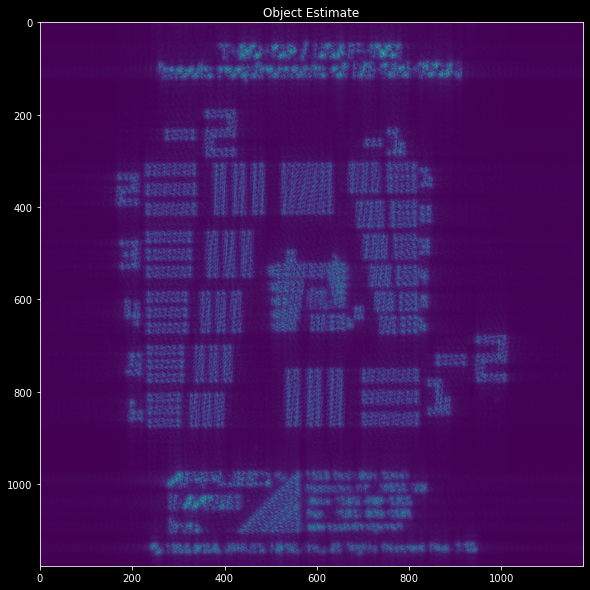

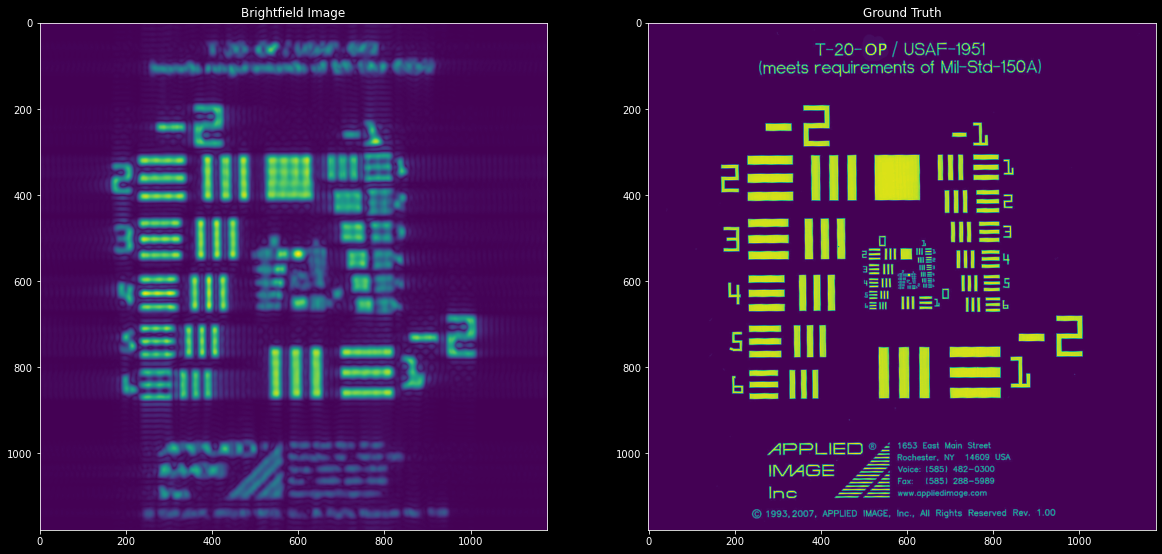

In [32]:
plt.figure(figsize = (10,10))
obj_est_norm = hardthresh(obj_est,0)
obj_est_norm = torch.sum(obj_est_norm/torch.amax(obj_est_norm), dim=0)
plt.imshow(obj_est_norm.detach().cpu().numpy())
plt.title('Object Estimate')
print(torch.norm(obj_est_norm))
# plt.colorbar()
# plt.clim([0,.9])

plt.figure(figsize = (20,20))
plt.subplot(1,2,2)
plt.imshow(obj)
# plt.colorbar()
plt.title('Ground Truth')

plt.subplot(1,2,1)
plt.imshow(measstack[-1,:,:].cpu().numpy())
plt.title('Brightfield Image')
# plt.colorbar()
# plt.clim([0,.3])

Text(0.5, 1.0, 'Reconstruction FFT')

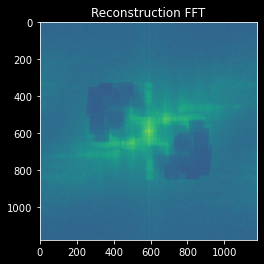

In [33]:
# compute the object reconstruction's fourier transform and plot
f = torch.fft.fftshift(torch.fft.fft2(obj_est[-1,:,:])).detach().cpu()
plt.imshow(torch.log10(torch.abs(f)))
plt.title('Reconstruction FFT')

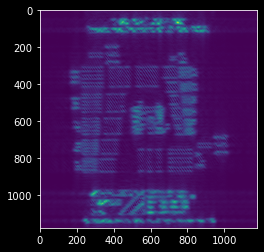

In [34]:
plt.imshow(obj_est[-1,:,:].detach().cpu().numpy())

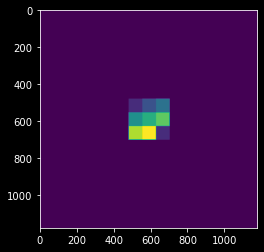

In [35]:
plt.imshow(aperture)